In [14]:
import torch
import matplotlib.pyplot as plt

from EWOthello.data.othello import *
from EWOthello.mingpt.dataset import ProbingDataset, CharDataset # AK's mingpt data child 
from EWOthello.mingpt.model import  GPTConfig, GPT_Mechanistic_Interp
import EWOthello.utils.plot_helpers as plt_util

device = "cpu"

In [11]:
othello = get(ood_num=-1, data_root=None, num_preload=1) 
game_dataset = CharDataset(othello) 

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 2.16 GB: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


Deduplicating...
Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.


Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/Dean_GPTv2_Synthetic_1L8H/GPT_Synthetic_1Layers_8Heads.ckpt


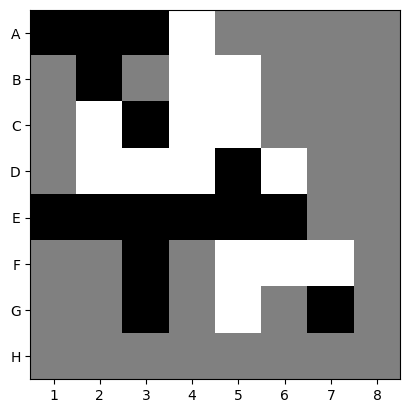

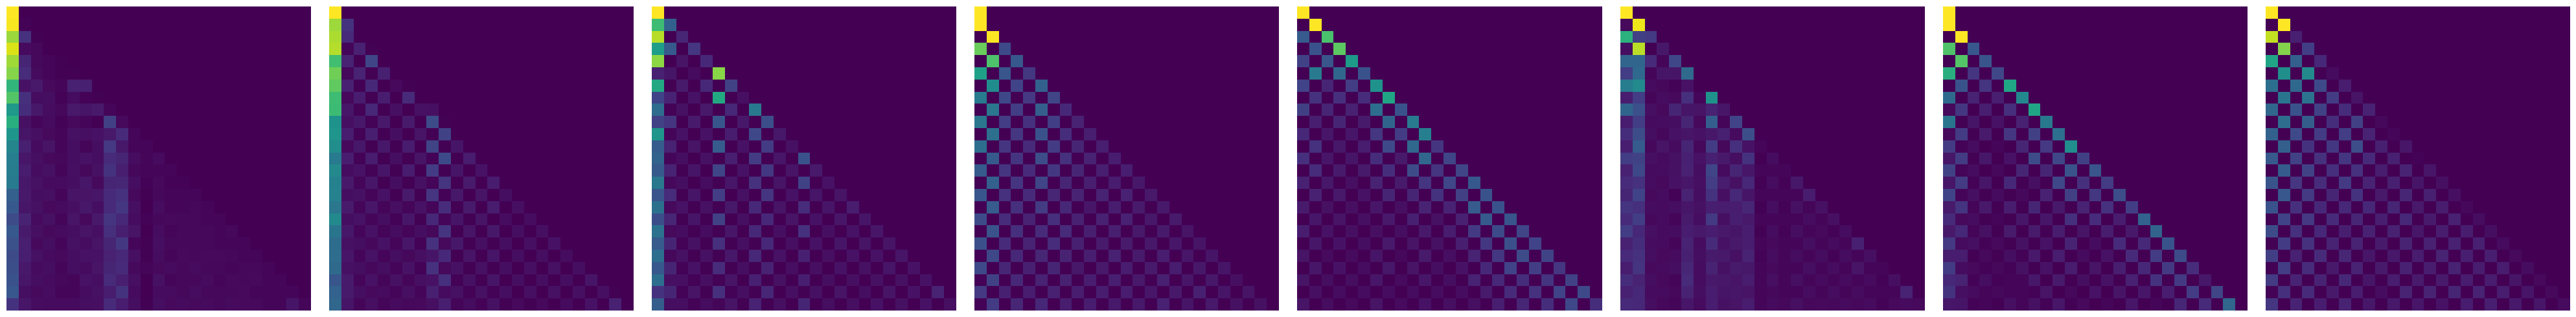

In [29]:
def get_GPT_internals(model_path, x, verbose=True):
    # Load the GPT Model for gameplay 
    n_layer = int(model_path[-5:-4])
    n_head = int(model_path[-3:-2])
    gpt_othello_ckpt = model_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose: 
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    
    # Load the model
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model_MI = GPT_Mechanistic_Interp(mconf)
    model_MI.load_state_dict(torch.load(gpt_othello_ckpt))
    model_MI.eval()
    model_MI = model_MI.to(device) 

    hold_att, hold_q, hold_k, hold_v, logits = model_MI(x[None])
    return np.stack(hold_att), np.stack(hold_q), np.stack(hold_k), np.stack(hold_v), logits

def visualize(model_path, x, game_length, verbose=True):
    n_layer = int(model_path[-5:-4])
    n_head = int(model_path[-3:-2])

    # Get the initial game board
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    ab = OthelloBoardState()
    ab.update(tbf[:game_length], prt=False)
    init_board = np.array(ab.get_state()).reshape(8,8)
    fig = plt.figure()
    ax = plt_util.addAxis(fig,1,1)
    ax[0].imshow(init_board, cmap="gray")
    plt_util.format_ax_boardImage(ax)

    hold_att, hold_q, hold_k, hold_v, logits = get_GPT_internals(model_path, x, verbose)

    fig = plt.figure(figsize=(5*n_head, 5*n_layer))
    ax = plt_util.addAxis(fig,n_layer, n_head)
    iter = 0
    for i in range(n_layer):
        for j in range(n_head):
            attn = hold_att[i,0,j,:game_length, :game_length]
            ax[iter].imshow(attn)
            ax[iter].set_axis_off()
            iter+=1
    fig.tight_layout()
    
    return

model_path = "../EWOthello/ckpts/Dean_GPTv2_Synthetic_1L8H/"
idx = 100
x, _ = game_dataset[idx]
game_length = 25
visualize(model_path, x, game_length, verbose=True)